In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import warnings
warnings.simplefilter('ignore')
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score
from scipy import stats

In [46]:
names = ['Sequence name','mcg','gvh','alm','mit','erl','pox','vac','nuc','class']

data_yeast = pd.read_csv('yeast.data', header = None, sep = '\s+', names = names)

data_pima = pd.read_csv('diabetes.csv')


## Question 1

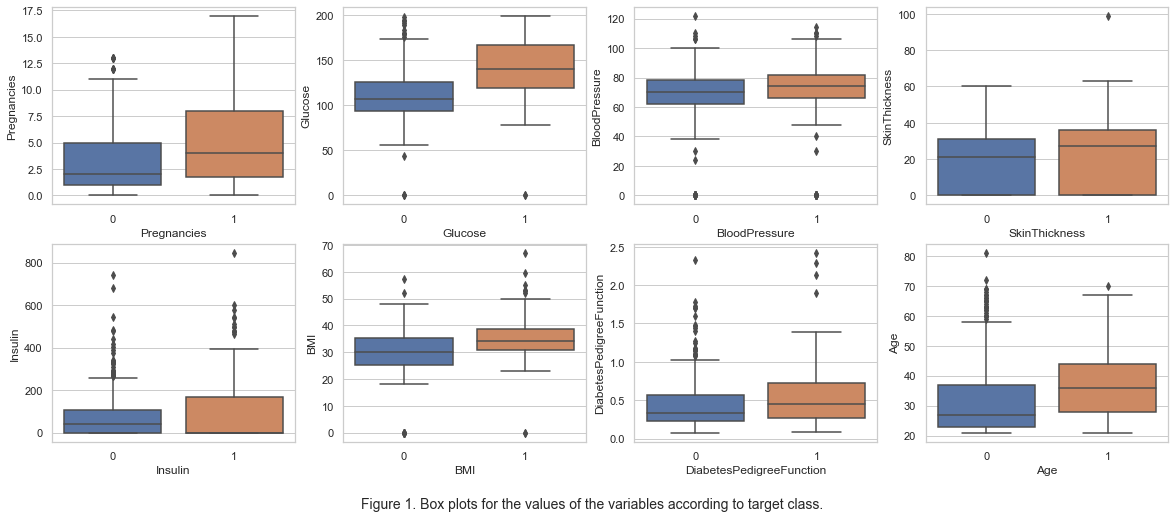

In [47]:
cols = data_pima.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 8))

txt="Figure 1. Box plots for the values of the variables according to target class."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=data_pima)
    ax[i//4, i%4].set(xlabel=cols[i])
plt.show();

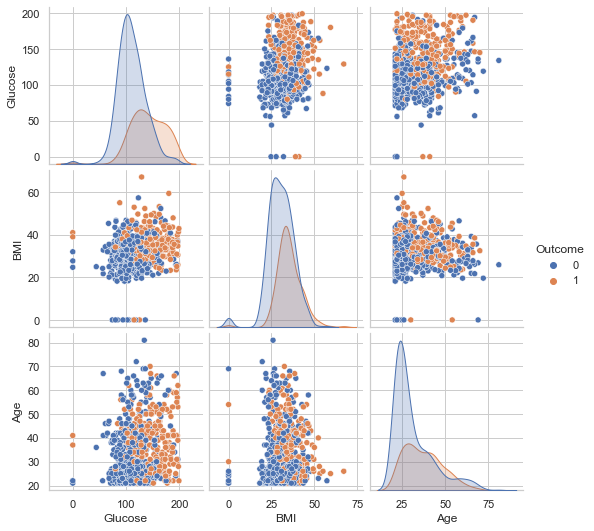

In [48]:
data_pima_sel = data_pima.drop(columns = ['BloodPressure', 'SkinThickness', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin'])
sns.pairplot(data_pima_sel, hue = 'Outcome');

Após análise aos gráficos apresentados, podemos observar rapidamente que as variáveis que melhor "separam" a variável alvo são a Glucose, BMI e Age. Contudo, as duas escolhidas (como requisitado pelo exercicio) foram a Glucose e BMI. A variável Age foi descartada pois tinha mais outliars.

## Methods comparison (kNN, Logistic Regression, QDA)

In [49]:
data_pima_clean = data_pima_sel[(data_pima['Glucose'] != 0) & (data_pima['BMI'] != 0)]

data_pima_clean = data_pima_clean.sample(frac=1).reset_index(drop=True)

In [74]:
data_pima_sel_final = data_pima_clean.drop(columns = 'Age')

column_names = ['Glucose', 'BMI']
temp = data_pima_sel_final[column_names].values
temp_scaled = MinMaxScaler().fit_transform(temp)

data_pima_sel_final[column_names] = temp_scaled


X = data_pima_sel_final.drop(columns = 'Outcome').values


y = data_pima_sel_final.loc[:,'Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify= y)

In [51]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

### Logistic Regression

In [52]:
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
y_pred_trainLogReg = modelLogReg.predict(x_train)
y_pred_testLogReg = modelLogReg.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainLogReg),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testLogReg), 4))


SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score.append(f1_score(y_test1, modelLogReg.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score),4),'+/-', round(np.std(score),4))

F1 score on training set:  0.5943 
F1 score on test set:  0.5455
F1 score on 5-fold test data:  0.5262 +/- 0.1354


### Quadratic Discriminant Analysis

In [53]:
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
y_pred_trainQDA = modelQDA.predict(x_train)
y_pred_testQDA = modelQDA.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainQDA),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testQDA), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_QDA = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_QDA.append(f1_score(y_test1, modelQDA.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_QDA),4),'+/-', round(np.std(score_QDA),4))


F1 score on training set:  0.6129 
F1 score on test set:  0.5495
F1 score on 5-fold test data:  0.4902 +/- 0.1367


### kNN

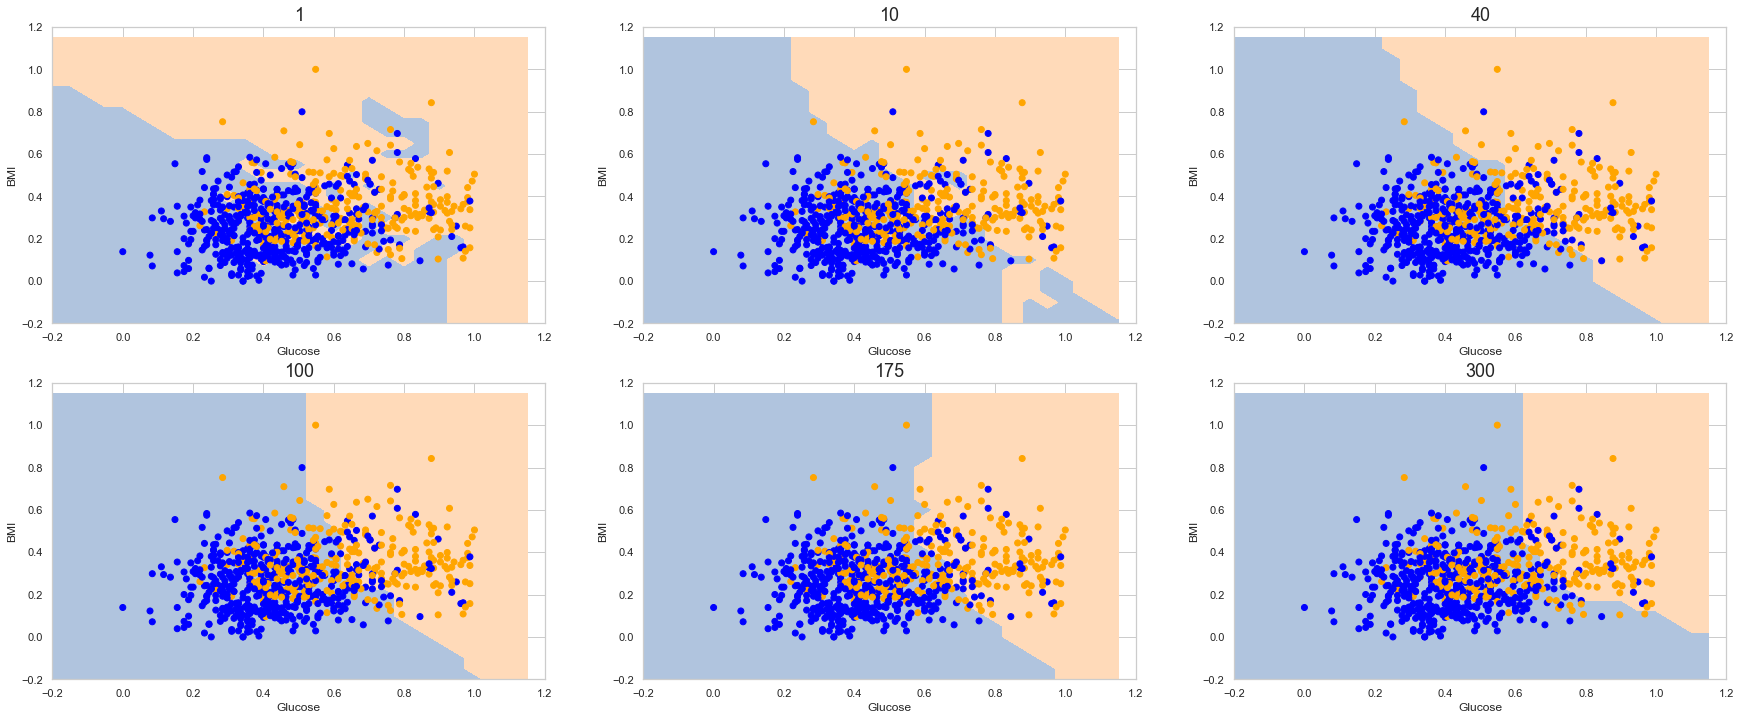

In [54]:
fig = plt.figure(figsize=(30,10))
k = [1,10,40,100,175,300]

for i in range(len(k)):
    modelkNN = kNN(n_neighbors=k[i])
    modelkNN.fit(x_train, y_train)
    ax = fig.add_subplot(2, 3, i+1)
    plot_classifier_boundary(modelkNN, X)
    ax.scatter(X[:,0],X[:,1],color=cmap(y))
    ax.set_title(k[i], fontsize = 18)
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BMI');

In [80]:
def valid_curve(model, x_train, y_train, n_jobs, scoring, param_range = np.array([*range(1,301)]), param_name="n_neighbors"):
    train_scores, test_scores = validation_curve(model, x_train, y_train, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(20, 8))
    plt.title("kNN Validation Curve")
    plt.xlabel("k Neighbors")
    plt.ylabel("Score")
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
    plt.legend(loc="best")
    plt.show();

    print("Best K is %d" %param_range[np.where(test_scores_mean == max(test_scores_mean))][0])

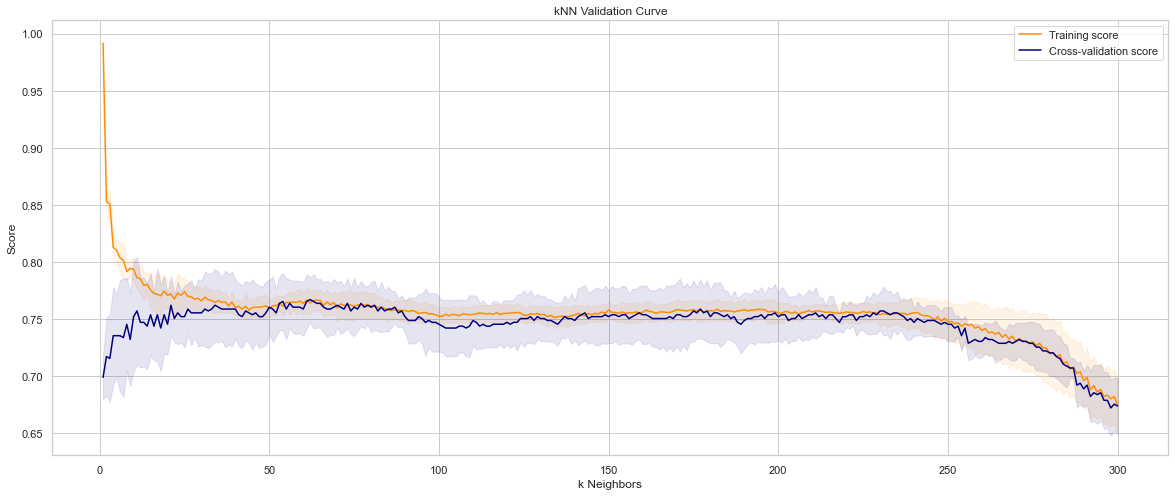

Best K is 62


In [55]:
#Determination of k
modelkNN = kNN()
param_range = [*range(1,301)]
rg = np.array([*range(1,301)])
train_scores, test_scores = validation_curve(modelkNN, x_train, y_train, param_name="n_neighbors", param_range=param_range, scoring="accuracy", n_jobs=6)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(20, 8))
plt.title("kNN Validation Curve")
plt.xlabel("k Neighbors")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
plt.legend(loc="best")
plt.show();

print("Best K is %d" %rg[np.where(test_scores_mean == max(test_scores_mean))][0])

In [56]:
modelkNN = kNN(n_neighbors=40)
modelkNN.fit(x_train, y_train)
y_pred_train_kNN = modelkNN.predict(x_train)
y_pred_test_kNN = modelkNN.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_train_kNN),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test_kNN), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_kNN = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_kNN.append(f1_score(y_test1, modelkNN.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_kNN),4),'+/-', round(np.std(score_kNN),4))

F1 score on training set:  0.6006 
F1 score on test set:  0.5435
F1 score on 5-fold test data:  0.5324 +/- 0.1118


In [57]:
#ROC AUC
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('kNN ROC AUC=%.3f' % (kNN_auc))

LR ROC AUC=0.797
QDA ROC AUC=0.792
kNN ROC AUC=0.804


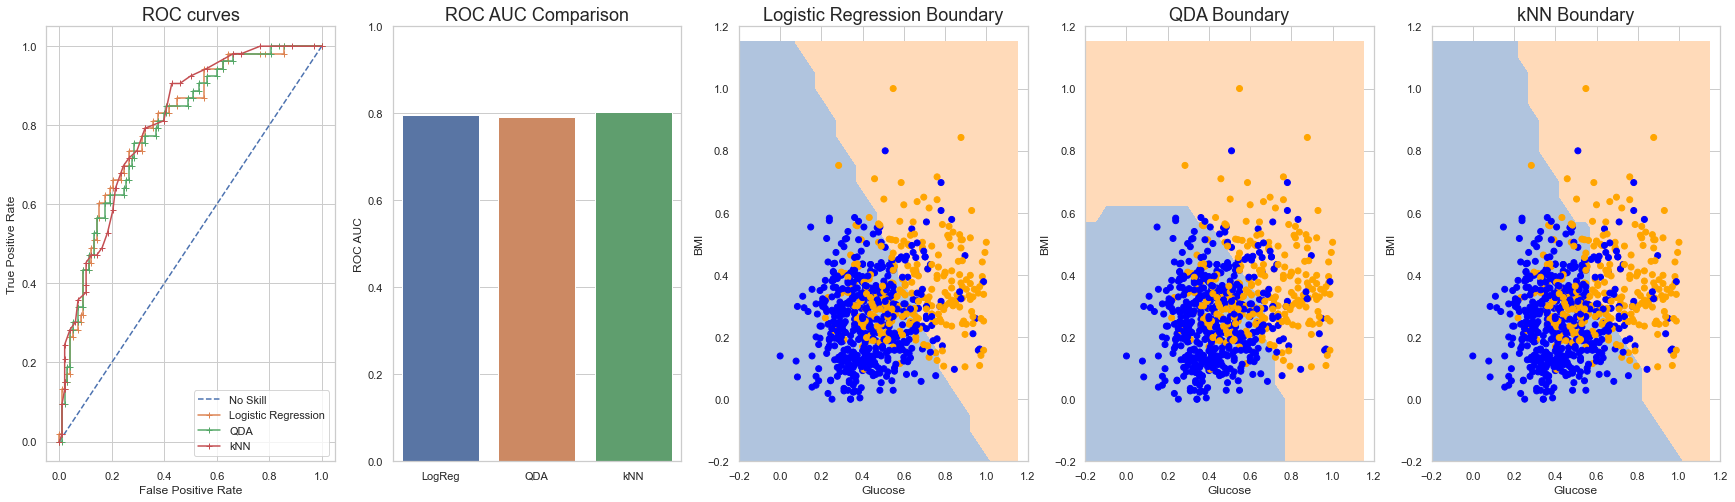

In [75]:
#ROC curves
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)

figs = plt.figure(figsize=(30,8))
# plot the roc curves
axs = figs.add_subplot(1, 5, 1)
axs.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
axs.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
axs.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC curves', fontsize = 18)
axs.legend();
##Barplot of AUCs
axs = figs.add_subplot(1, 5, 2)
sns.barplot(y=[LogReg_auc,QDA_auc,kNN_auc], x=['LogReg', 'QDA', 'kNN'], ax=axs)
axs.set_ylim(0,1)
axs.set_title('ROC AUC Comparison', fontsize = 18)
axs.set_ylabel('ROC AUC');

model_list = [(modelLogReg,'Logistic Regression Boundary') , (modelQDA, 'QDA Boundary'), (modelkNN, 'kNN Boundary')]

for i in range(3,6,1):
    axs = figs.add_subplot(1, 5, i)
    plot_classifier_boundary(model_list[i-3][0],X)
    axs.scatter(X[:,0],X[:,1],color=cmap(y))
    axs.set_xlabel('Glucose')
    axs.set_ylabel('BMI');
    axs.set_title(model_list[i-3][1], fontsize = 18)

plt.show();

## Question 2

In [72]:
#sns.pairplot(data_yeast, hue='class', diag_kind="hist", corner=True);

### normalization

In [60]:
MinMaxSca = MinMaxScaler()
data_yeast[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']] = MinMaxSca.fit_transform(data_yeast.loc[:,['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']])

### Separation in train data and test data

In [61]:
X = data_yeast.loc[:, ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']].values
Y = data_yeast.loc[:,'class'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y, shuffle=True)

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logistic regression

In [62]:
modelLR = LogReg()
modelLR.fit(X_train, Y_train)
Y_pred_trainLogReg = modelLR.predict(X_train)
Y_pred_testLogReg = modelLR.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))

f1score_LogReg = []
accscore_LogReg = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_LogReg.append(f1_score(Y_test1, modelLR.predict(X_test1), average='weighted'))
    accscore_LogReg.append(accuracy_score(Y_test1, modelLR.predict(X_test1)))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_LogReg),4),'+/-', round(np.std(f1score_LogReg),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testLogReg, digits=3))

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5383 +/- 0.0319

Classification report:
               precision    recall  f1-score   support

         CYT      0.504     0.742     0.600        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.631     0.477     0.543        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.354     0.355     0.350       297
weighted avg      0.537     0.566     0.541       297



### kNN

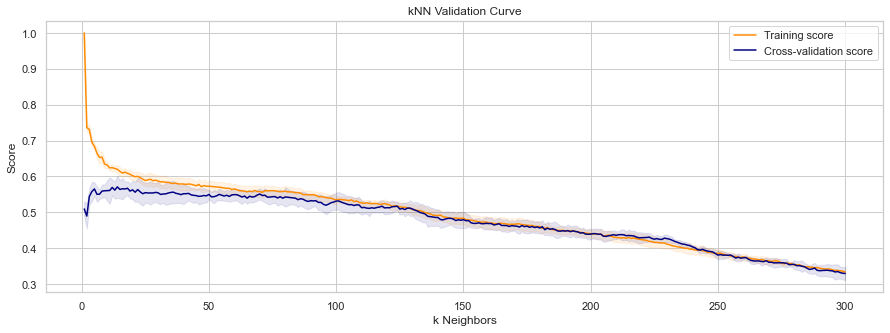

Best K is 14


In [63]:
modelknn = kNN()
param_range = [*range(1,301)]
rg = np.array([*range(1,301)])
train_scores, test_scores = validation_curve(modelknn, X_train, Y_train, param_name="n_neighbors", param_range=param_range, cv = 4, scoring="f1_weighted", n_jobs=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15, 5))
plt.title("kNN Validation Curve")
plt.xlabel("k Neighbors")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
plt.legend(loc="best")
plt.show()

print("Best K is %d" %rg[np.where(test_scores_mean == max(test_scores_mean))][0])

In [64]:
modelknn = kNN(n_neighbors=14)
modelknn.fit(X_train, Y_train)
Y_pred_trainknn = modelknn.predict(X_train)
Y_pred_testknn = modelknn.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))

f1score_knn = []
accscore_knn = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_knn.append(f1_score(Y_test1, modelknn.predict(X_test1), average='weighted'))
    accscore_knn.append(accuracy_score(Y_test1, modelknn.predict(X_test1)))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_knn),4),'+/-', round(np.std(f1score_knn),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testknn, digits=3))

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5406
Weighted F1 score on 5-fold test data:  0.5592 +/- 0.0471

Classification report:
               precision    recall  f1-score   support

         CYT      0.522     0.634     0.573        93
         ERL      1.000     1.000     1.000         1
         EXC      0.667     0.571     0.615         7
         ME1      0.429     0.667     0.522         9
         ME2      0.500     0.200     0.286        10
         ME3      0.710     0.688     0.698        32
         MIT      0.652     0.612     0.632        49
         NUC      0.557     0.512     0.533        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.572       297
   macro avg      0.570     0.538     0.543       297
weighted avg      0.567     0.572     0.564       297



### Decision tree

In [65]:
modeltree = DTreeClass()
modeltree.fit(X_train, Y_train)
Y_pred_traintree = modeltree.predict(X_train)
Y_pred_testtree = modeltree.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_traintree, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testtree, average='weighted'), 4))

f1score_tree = []
accscore_tree = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_tree.append(f1_score(Y_test1, modeltree.predict(X_test1), average='weighted'))
    accscore_tree.append(accuracy_score(Y_test1, modeltree.predict(X_test1)))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_tree),4),'+/-', round(np.std(f1score_tree),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testtree, digits=3))

Weighted F1 score on training set:  1.0 
Weighted F1 score on test set:  0.4806
Weighted F1 score on 5-fold test data:  0.4739 +/- 0.0456

Classification report:
               precision    recall  f1-score   support

         CYT      0.526     0.538     0.532        93
         ERL      0.000     0.000     0.000         1
         EXC      0.300     0.429     0.353         7
         ME1      0.556     0.556     0.556         9
         ME2      0.222     0.200     0.211        10
         ME3      0.667     0.625     0.645        32
         MIT      0.488     0.408     0.444        49
         NUC      0.472     0.488     0.480        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.478       297
   macro avg      0.323     0.324     0.322       297
weighted avg      0.485     0.478     0.481       297



In [66]:
def model_grid_search(model, param_grid, cv, scoring, n_jobs): # "cv - integer, to specify the number of folds in a `(Stratified) KFold`,"
    model_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, refit = True, scoring= scoring, n_jobs = n_jobs)
    model_grid.fit(X_train, Y_train)
    print(f"Best estimator: {model_grid.best_estimator_} \n  Best score: {model_grid.best_score_} \n Best Params: {model_grid.best_params_}")
    return model_grid.best_estimator_

In [67]:
max_depth = [None] + [x for x in np.arange(1,20,4)]
min_sample_split= np.arange(2, 10,2)
min_sample_leaf = np.arange(1,5)
ccp_alpha = np.arange(0.01,100, 10)

param_grid_tree = {"criterion": ['gini', "entropy"],\
              "splitter": ['best',"random"],\
              "max_depth": max_depth,\
              "min_samples_split": min_sample_split,\
              "min_samples_leaf": min_sample_leaf, \
              "ccp_alpha": ccp_alpha}

In [68]:
tree_grid = model_grid_search(modeltree, param_grid_tree, 5, "f1_weighted", 2) 

Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       min_samples_leaf=4) 
  Best score: 0.5669393207369835 
 Best Params: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}


In [69]:
modeltree = tree_grid
Y_pred_traintree = modeltree.predict(X_train)
Y_pred_testtree = modeltree.predict(X_test)
print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_traintree, average='weighted'),4), 
      '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testtree, average='weighted'), 4))

f1score_tree = []
for train_index, test_index in SKF.split (X_test, Y_test):
    X_test1 = X_test[test_index]
    Y_test1 = Y_test[test_index]
    f1score_tree.append(f1_score(Y_test1, modeltree.predict(X_test1), average='weighted'))
print('Weighted F1 score on 5-fold test data: ',round(np.mean(f1score_tree),4),'+/-', round(np.std(f1score_tree),4))
print('\nClassification report:\n',classification_report(Y_test, Y_pred_testtree, digits=3))

Weighted F1 score on training set:  0.5986 
Weighted F1 score on test set:  0.5512
Weighted F1 score on 5-fold test data:  0.5519 +/- 0.0611

Classification report:
               precision    recall  f1-score   support

         CYT      0.526     0.538     0.532        93
         ERL      0.000     0.000     0.000         1
         EXC      0.571     0.571     0.571         7
         ME1      0.571     0.889     0.696         9
         ME2      0.500     0.300     0.375        10
         ME3      0.711     0.844     0.771        32
         MIT      0.617     0.592     0.604        49
         NUC      0.522     0.547     0.534        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.402     0.428     0.408       297
weighted avg      0.542     0.566     0.551       297



### Achieved results comparison

In [70]:

stats_f1,pvalue_f1 = stats.f_oneway(f1score_LogReg, f1score_knn, f1score_tree)
stats_acc, pvalue_acc = stats.f_oneway(accscore_LogReg, accscore_knn, accscore_tree)


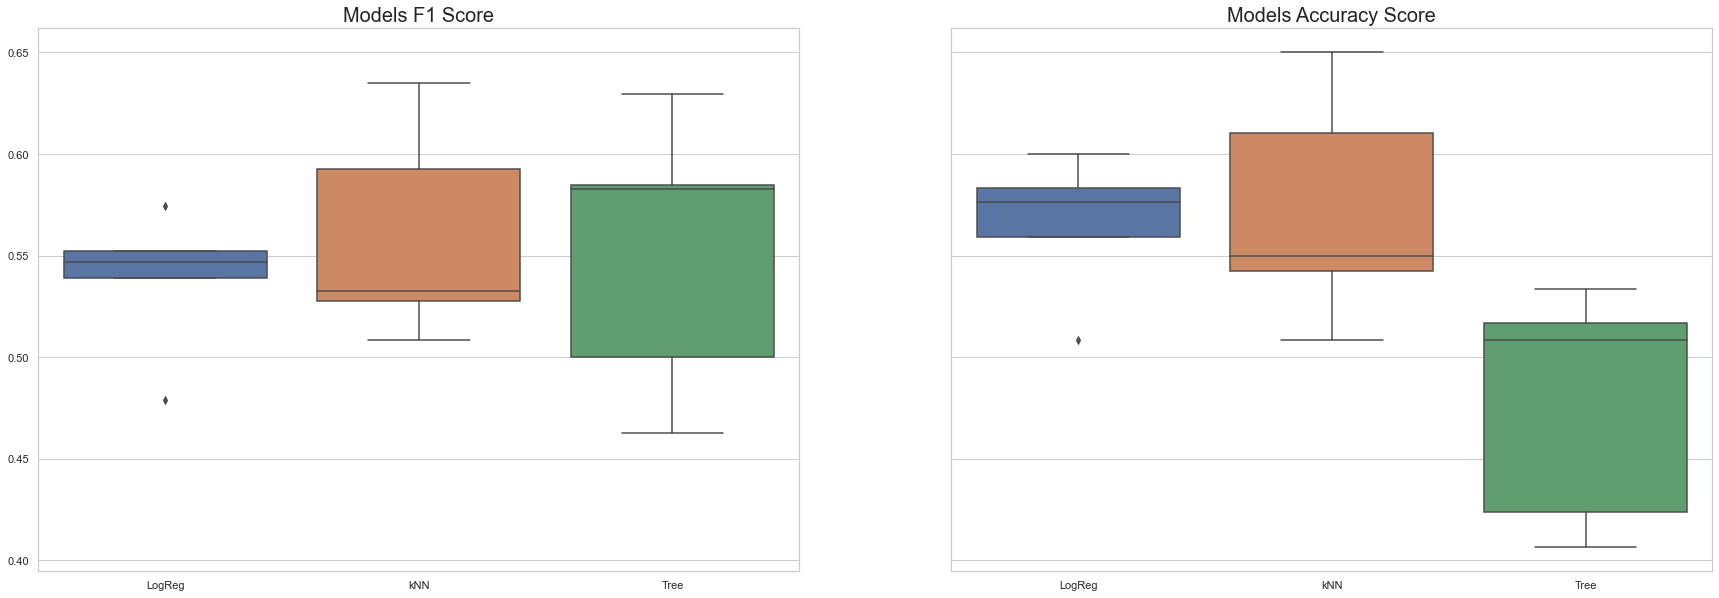

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
sns.set_theme(style="whitegrid")
ax[0].set_title('Models F1 Score', fontsize = 20)
ax[1].set_title('Models Accuracy Score', fontsize = 20)
sns.boxplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[0])
sns.boxplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[1]);